In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataframes/incidenti_tfl_2019.csv")
df.head()

,$type,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345906,51.511963,-0.028211,On Commercial Road Near The Junction With Burd...,2019-01-03T01:20:00Z,Slight,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345907,51.371636,-0.117621,On Purley Way 20 metres north of The Junction ...,2019-01-02T22:45:00Z,Slight,Croydon,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345908,51.514951,-0.072747,On Whitechapel High Street Near The Junction W...,2019-01-02T18:45:00Z,Slight,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345909,51.519173,-0.262356,On western Avenue 10 metres south of The Junct...,2019-01-03T08:41:00Z,Slight,Ealing,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,Tfl.Api.Presentation.Entities.AccidentStats.Ac...,345910,51.565743,-0.136308,On Macdonald Road 30 metres south of The Junct...,2019-01-03T08:37:00Z,Slight,Islington,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


In [2]:
df.drop(columns=['$type'], inplace=True)

# converting 'severity' in cardinal indicator
df['severity'] = df['severity'].map({'Slight': 0, 'Serious': 1, 'Fatal': 2})
df.head()

,id,lat,lon,location,date,severity,borough,casualties,vehicles
0,345906,51.511963,-0.028211,On Commercial Road Near The Junction With Burd...,2019-01-03T01:20:00Z,0,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
1,345907,51.371636,-0.117621,On Purley Way 20 metres north of The Junction ...,2019-01-02T22:45:00Z,0,Croydon,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
2,345908,51.514951,-0.072747,On Whitechapel High Street Near The Junction W...,2019-01-02T18:45:00Z,0,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
3,345909,51.519173,-0.262356,On western Avenue 10 metres south of The Junct...,2019-01-03T08:41:00Z,0,Ealing,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...
4,345910,51.565743,-0.136308,On Macdonald Road 30 metres south of The Junct...,2019-01-03T08:37:00Z,0,Islington,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...


In [3]:
# Compute accident counts per borough
borough_accident_counts = df.groupby('borough').size().reset_index(name='total_accidents')

# Compute average severity per borough
borough_avg_severity = df.groupby('borough')['severity'].mean().reset_index(name='avg_severity')

# Merge stats
borough_risk_stats = pd.merge(borough_accident_counts, borough_avg_severity, on='borough')

# View results
borough_risk_stats

,borough,total_accidents,avg_severity
0,Barking and Dagenham,1212,0.145215
1,Barnet,1896,0.150844
2,Bexley,950,0.155789
3,Brent,1722,0.141696
4,Bromley,1418,0.150917
5,Camden,1838,0.157780
6,City of London,638,0.231975
7,City of Westminster,3032,0.160290
8,Croydon,1908,0.174004
9,Ealing,1966,0.143438


In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
borough_risk_stats[['total_accidents', 'avg_severity']] = scaler.fit_transform(
    borough_risk_stats[['total_accidents', 'avg_severity']]
)

# Compute a combined risk score (weighted sum)
borough_risk_stats['risk_score'] = (
    0.7 * borough_risk_stats['total_accidents'] + 0.3 * borough_risk_stats['avg_severity']
)

# Sort by risk score
borough_risk_stats = borough_risk_stats.sort_values(by='risk_score', ascending=False)
borough_risk_stats


,borough,total_accidents,avg_severity,risk_score
7,City of Westminster,1.000000,0.330814,0.799244
22,Lambeth,0.728488,0.370743,0.621165
28,Southwark,0.646617,0.201017,0.512937
30,Tower Hamlets,0.665831,0.147759,0.510409
8,Croydon,0.530493,0.458835,0.508996
32,Wandsworth,0.522974,0.474305,0.508373
12,Hackney,0.456140,0.485668,0.464999
5,Camden,0.501253,0.307382,0.443092
1,Barnet,0.525480,0.242631,0.440625
9,Ealing,0.554720,0.173500,0.440354


In [5]:
# Define risk categories
borough_risk_stats['risk_level'] = pd.qcut(
    borough_risk_stats['risk_score'], 
    q=3,  # 3 groups: Low, Medium, High
    labels=['Low', 'Medium', 'High']
)

borough_risk_stats


,borough,total_accidents,avg_severity,risk_score,risk_level
7,City of Westminster,1.000000,0.330814,0.799244,High
22,Lambeth,0.728488,0.370743,0.621165,High
28,Southwark,0.646617,0.201017,0.512937,High
30,Tower Hamlets,0.665831,0.147759,0.510409,High
8,Croydon,0.530493,0.458835,0.508996,High
32,Wandsworth,0.522974,0.474305,0.508373,High
12,Hackney,0.456140,0.485668,0.464999,High
5,Camden,0.501253,0.307382,0.443092,High
1,Barnet,0.525480,0.242631,0.440625,High
9,Ealing,0.554720,0.173500,0.440354,High


In [6]:
df_risk = df.merge(borough_risk_stats[["borough", "risk_level"]], on="borough", how="left")
df_risk.head()

,id,lat,lon,location,date,severity,borough,casualties,vehicles,risk_level
0,345906,51.511963,-0.028211,On Commercial Road Near The Junction With Burd...,2019-01-03T01:20:00Z,0,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,High
1,345907,51.371636,-0.117621,On Purley Way 20 metres north of The Junction ...,2019-01-02T22:45:00Z,0,Croydon,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,High
2,345908,51.514951,-0.072747,On Whitechapel High Street Near The Junction W...,2019-01-02T18:45:00Z,0,Tower Hamlets,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,High
3,345909,51.519173,-0.262356,On western Avenue 10 metres south of The Junct...,2019-01-03T08:41:00Z,0,Ealing,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,High
4,345910,51.565743,-0.136308,On Macdonald Road 30 metres south of The Junct...,2019-01-03T08:37:00Z,0,Islington,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,[{'$type': 'Tfl.Api.Presentation.Entities.Acci...,Medium


In [7]:
df_old = pd.read_csv("dataframes/final_df.csv")
df_old.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Car,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,0
3,345909,51.519173,-0.262356,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0


In [8]:
borough_risk_stats

,borough,total_accidents,avg_severity,risk_score,risk_level
7,City of Westminster,1.000000,0.330814,0.799244,High
22,Lambeth,0.728488,0.370743,0.621165,High
28,Southwark,0.646617,0.201017,0.512937,High
30,Tower Hamlets,0.665831,0.147759,0.510409,High
8,Croydon,0.530493,0.458835,0.508996,High
32,Wandsworth,0.522974,0.474305,0.508373,High
12,Hackney,0.456140,0.485668,0.464999,High
5,Camden,0.501253,0.307382,0.443092,High
1,Barnet,0.525480,0.242631,0.440625,High
9,Ealing,0.554720,0.173500,0.440354,High


In [9]:
df_old = df_old.merge(df_risk[["id", "risk_level"]], on="id", how="left")
df_old.head()

,id,lat,lon,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,borough_Camden,...,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+,risk_level
0,345906,51.511963,-0.028211,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,High
1,345907,51.371636,-0.117621,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,High
2,345908,51.514951,-0.072747,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,High
3,345909,51.519173,-0.262356,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,High
4,345910,51.565743,-0.136308,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,Medium


In [10]:
df_copy = df_old.copy()
borough_cols = [col for col in df_copy.columns if col.startswith('borough_')]
df_copy.drop(columns=borough_cols, inplace=True, errors='ignore')
print(df_copy.columns)


Index(['id', 'lat', 'lon', 'severity', 'time_of_day_Night',
       'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening',
       'month', 'day_of_week', 'Car', 'Heavy_Vehicles', 'Motorcycle', 'Other',
       'Pedalcycle', 'casualty_age_0-23', 'casualty_age_24-30',
       'casualty_age_31-38', 'casualty_age_39-50', 'casualty_age_50+',
       'risk_level'],
      dtype='object')


In [11]:
df_copy.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,...,Heavy_Vehicles,Motorcycle,Other,Pedalcycle,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+,risk_level
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,...,0,0,0,0,0,1,0,0,0,High
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,...,0,0,0,0,0,0,0,1,0,High
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,...,0,1,0,1,0,1,0,0,0,High
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,...,0,0,0,0,0,0,0,1,0,High
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,...,0,1,0,0,1,0,0,0,0,Medium


In [12]:
df_copy.drop(columns=['Car', 'Heavy_Vehicles', 'Motorcycle', 'Other',
       'Pedalcycle', 'casualty_age_0-23', 'casualty_age_24-30',
       'casualty_age_31-38', 'casualty_age_39-50', 'casualty_age_50+'], inplace=True)
df_copy.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,High
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,High
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,High
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,High
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,Medium


In [13]:
df_copy['risk_level'] = df_copy['risk_level'].map({'Low': 0, 'Medium': 1, 'High': 2})
df_copy.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,2
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,2
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,2
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encode risk_level as integers
le = LabelEncoder()
df_copy["risk_level_encoded"] = le.fit_transform(df_copy["risk_level"])

# Drop the original categorical column
df_copy = df_copy.drop(columns=["risk_level"])

In [15]:
df_copy.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,2
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,2
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,2
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,2
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,1


In [16]:
df_copy.to_csv('Risk_level_Dataset.csv', index=False)

In [75]:
X = df_copy.drop(columns=['severity', 'id'])
y = df_copy['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 9)
(10126, 9)
(40500,)
(10126,)


In [76]:
df_copy.head()

,id,lat,lon,severity,time_of_day_Night,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,month,day_of_week,risk_level_encoded
0,345906,51.511963,-0.028211,0,1,0,0,0,1,3,0
1,345907,51.371636,-0.117621,0,0,0,0,1,1,2,0
2,345908,51.514951,-0.072747,0,0,0,0,1,1,2,0
3,345909,51.519173,-0.262356,0,0,1,0,0,1,3,0
4,345910,51.565743,-0.136308,0,0,1,0,0,1,3,2


In [77]:
base_xgb_model = XGBClassifier(random_state=42)
base_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.849     0.998     0.917      8547
           1      0.764     0.036     0.069      1527
           2      1.000     0.058     0.109        52

    accuracy                          0.848     10126
   macro avg      0.871     0.364     0.365     10126
weighted avg      0.837     0.848     0.785     10126



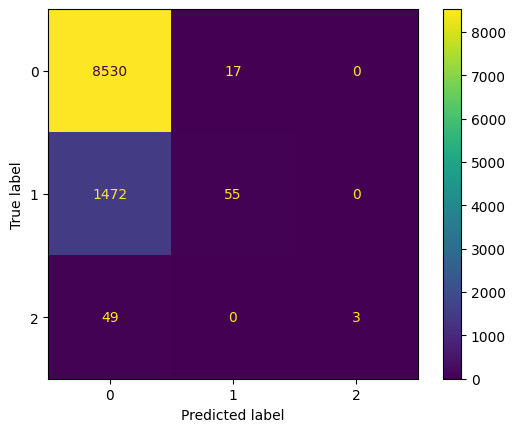

In [78]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = base_xgb_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

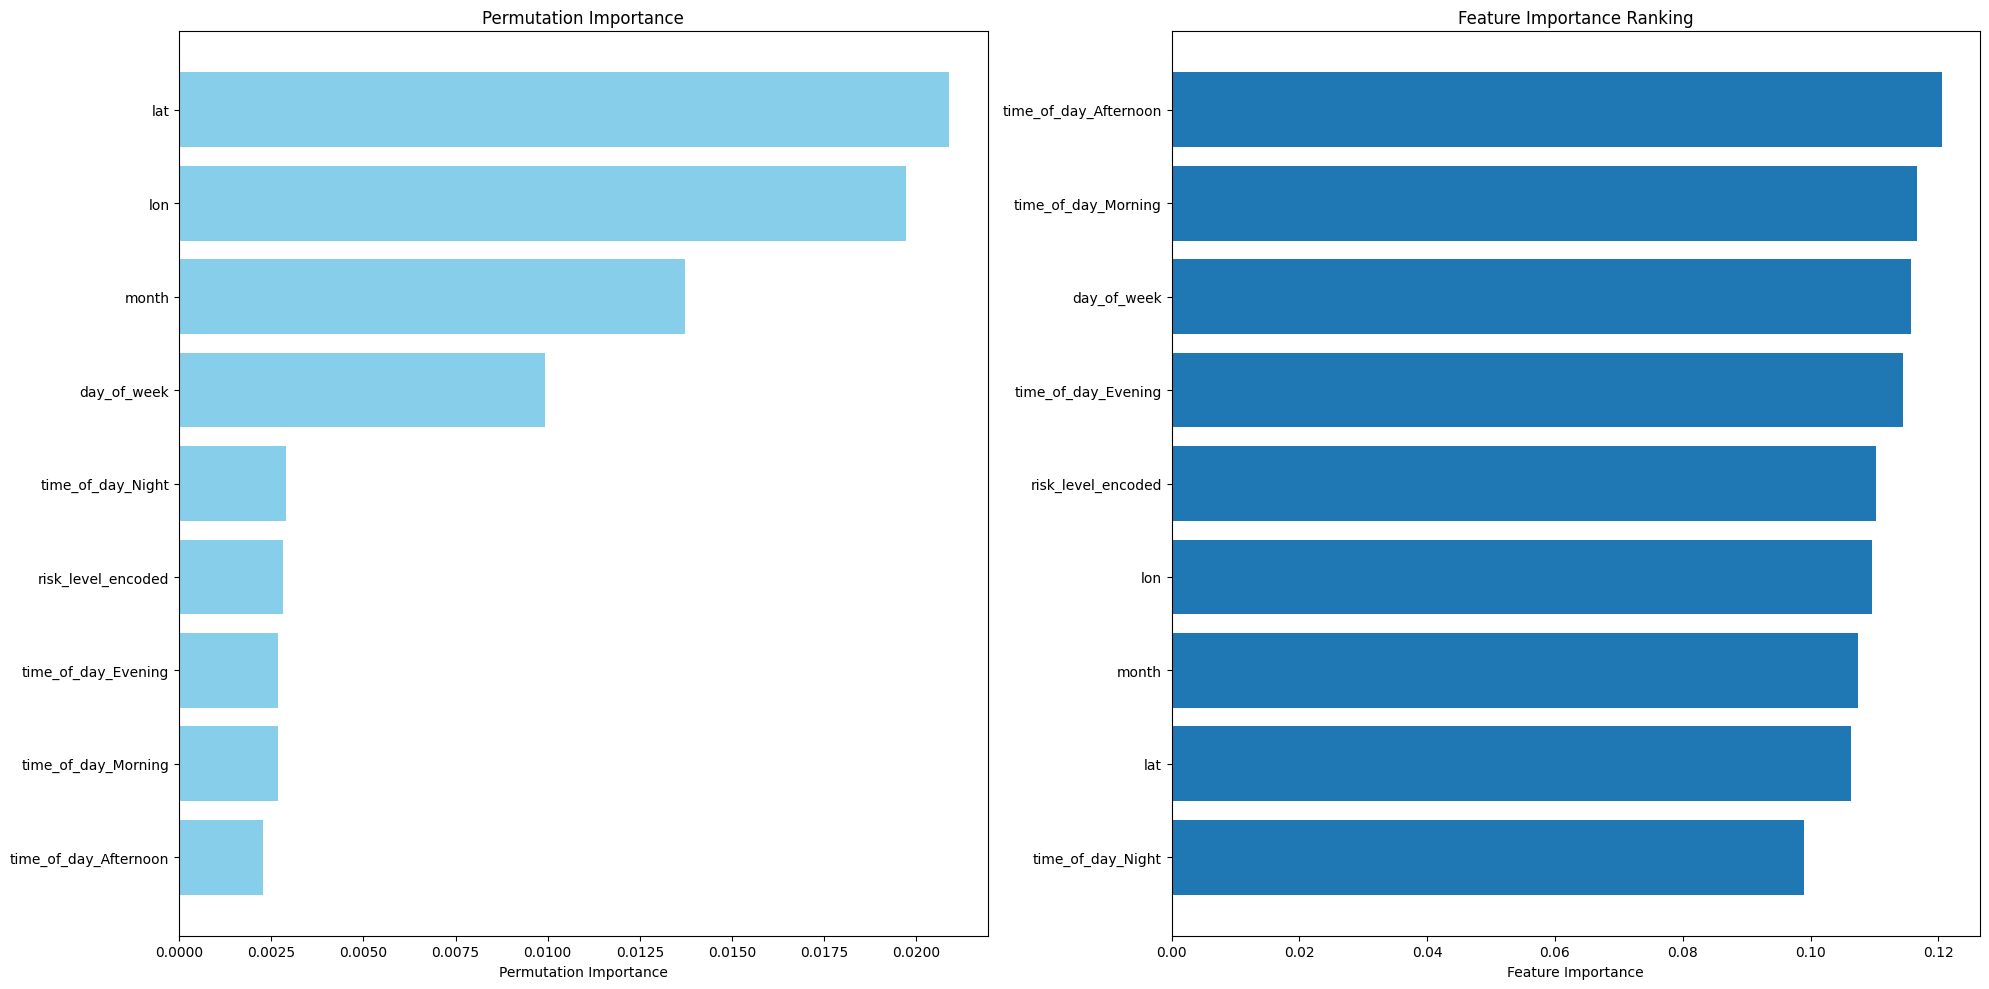

In [79]:
from sklearn.inspection import permutation_importance
feature_importance = base_xgb_model.feature_importances_

r_train = permutation_importance(base_xgb_model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()


In [80]:
random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

sample_XGB = XGBClassifier(random_state=random_state)
sample_XGB.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

              precision    recall  f1-score   support

           0      0.914     0.752     0.825      8547
           1      0.310     0.605     0.410      1527
           2      0.375     0.808     0.512        52

    accuracy                          0.730     10126
   macro avg      0.533     0.722     0.582     10126
weighted avg      0.820     0.730     0.761     10126



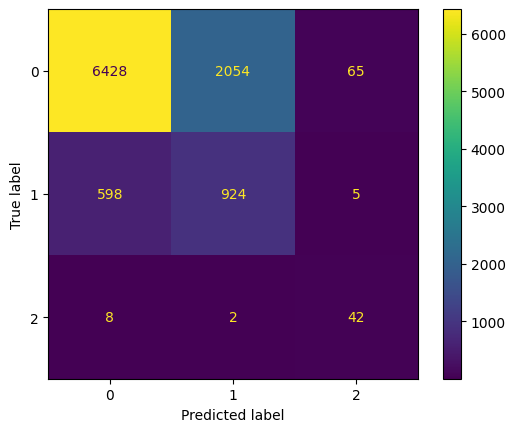

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = sample_XGB.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

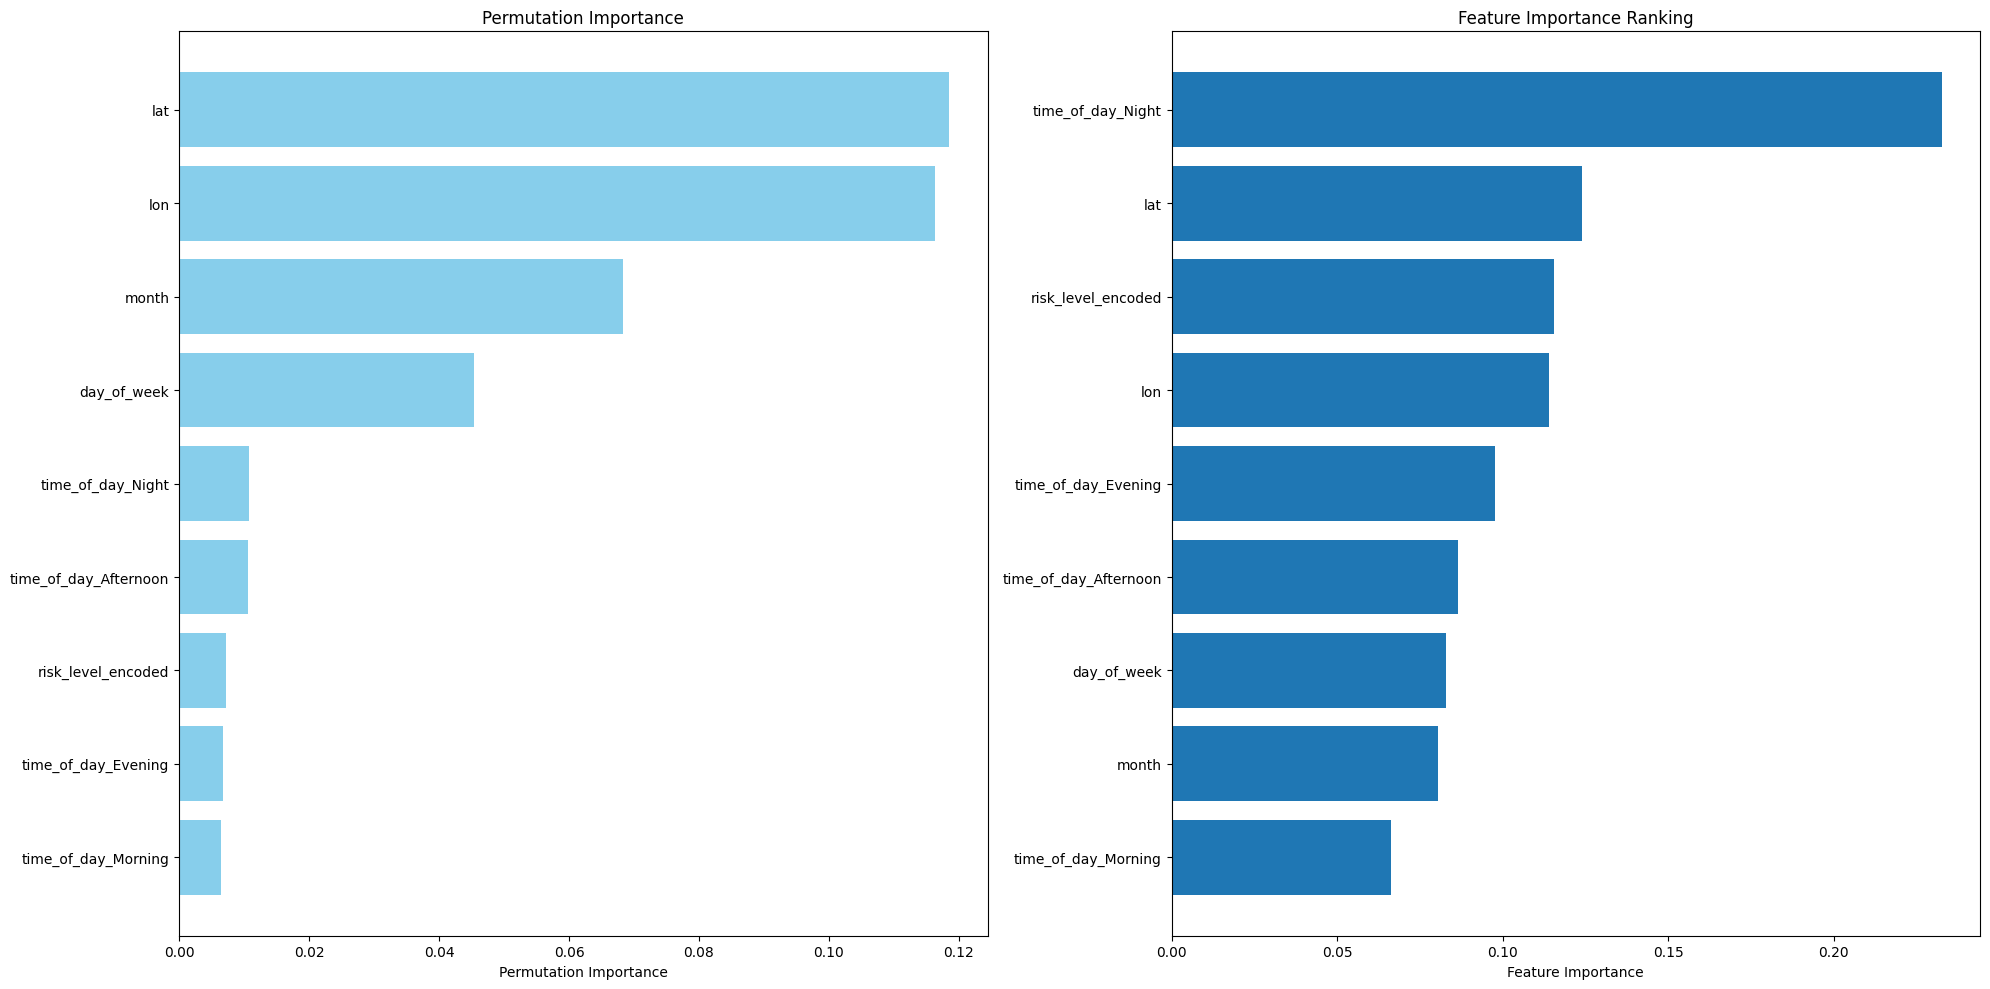

In [82]:
from sklearn.inspection import permutation_importance
feature_importance = sample_XGB.feature_importances_

r_train = permutation_importance(sample_XGB, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

sorted_idx = r_train.importances_mean.argsort()

# Assuming X_train.columns and feature importance arrays are defined
sorted_idx_perm = np.argsort(r_train.importances_mean)
sorted_idx_feat = np.argsort(feature_importance)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size as needed

# First plot: Permutation Importance
axes[0].barh(X_train.columns[sorted_idx_perm], r_train.importances_mean[sorted_idx_perm], color="skyblue")
axes[0].set_xlabel("Permutation Importance")
axes[0].set_title("Permutation Importance")

# Second plot: Feature Importance
axes[1].barh(X_train.columns[sorted_idx_feat], feature_importance[sorted_idx_feat])
axes[1].set_xlabel("Feature Importance")
axes[1].set_title("Feature Importance Ranking")

# Adjust layout for readability
plt.tight_layout()
plt.show()